In [1]:
import os
import glob
import time
import random
import json
import numpy as np
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from scipy.special import hyp2f1, factorial, comb
from sympy.functions.combinatorial.numbers import stirling
from math import atan, cos, sin

In [2]:
import sys
sys.path.insert(0,'..')

from image_processing.preprocessing import get_centroid

In [33]:
from image_processing.preprocessing import (
    remove_padding,
    pad_to_square
)

from image_processing.shape_normalization.p2d_bimoment import normalize as p2d_bimoment_normalization

def preprocess_image_moment(img, N):
    
    img = remove_padding(img)
    img_norm = p2d_bimoment_normalization(img, beta=2, w0=0.5)
    img_norm = pad_to_square(img_norm, max(img_norm.shape))
    img_norm = cv2.resize(img_norm, (N, N))    
    return img_norm

import matplotlib as mpl

FONT_PATH = '../fonts/heiti.ttf'

# show a list of images
def show(imgs, col=5, titles=None, gray=True, chinese_title=False):
    
    chinese_font = mpl.font_manager.FontProperties(fname=FONT_PATH)

    row = max((len(imgs) + col - 1) // col, 2)
    plt.figure(figsize=(col * 2.5, row * 2))
    
    for i in range(len(imgs)):
        ax = plt.subplot(row, col, i + 1)
        if gray:
            plt.imshow(imgs[i], 'gray')
        else:
            plt.imshow(imgs[i])
        if titles is not None:
            if chinese_title:
                plt.title(titles[i], fontproperties=chinese_font, fontsize=16)
            else:
                plt.title(titles[i])
        plt.axis("off")

In [4]:
def get_central_moment(img, a, b):
    h, w = img.shape
    x_c, y_c = get_centroid(f)
    x = ((np.array(range(w)) - x_c) ** a).astype('int64')
    y = ((np.array(range(h)) - y_c) ** b).astype('int64')
    x, y = np.meshgrid(x, y)
    retval = np.multiply(x, y)
    retval = np.multiply(retval, img.astype('int64'))
    retval = np.sum(retval)
    return retval if retval > 0 else 1e-100 # TODO


# i1, j1 exclusive
def call_fill_memo(fill_memo_func, memo, i0, i1, j0, j1, **kwargs):
    for i in range(i0, i1):
        for j in range(j0, j1):
            fill_memo_func(i, j, **kwargs)
    return memo[i0:i1, j0:j1]


def init_memo_c(N, M):
    memo_c = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
    memo_c[:] = np.nan
    def c(n, i, N, p):
        if np.isnan(memo_c[n, i]):
            memo_c[n, i] = 0
            for k in range(i, n + 1):
                num = (-1 ** k) * factorial(n) * factorial(N - k)
                denom = (p ** k) * factorial(N) * factorial(k) * factorial(n - k)
                memo_c[n, i] += num / denom * stirling(k, i, kind=1)
        return memo_c[n, i]
    return memo_c, c


def init_memo_d(N, M):
    memo_d = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
    memo_d[:] = np.nan
    def d(i, s, N, p):
        if np.isnan(memo_d[i, s]):
            memo_d[i, s] = 0
            for m in range(s, i + 1):
                num = (-1 ** s) * factorial(m) * factorial(N) * (p ** m)
                denom = factorial(m - s) * factorial(N - m) * factorial(m)
                memo_d[i, s] += stirling(i, m, kind=2) * num / (denom + 1e-100) # TODO
        return memo_d[i, s]
    return memo_d, d


def init_memo_K(N, M):
    memo_K = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
    memo_K[:] = np.nan
    def K(n, x, p, N):
        if np.isnan(memo_K[n, x]):
            memo_K[n, x] = hyp2f1(-n, -x, -N, 1/p)
            if np.isnan(memo_K[n, x]):
                memo_K[n, x] = 0
        return memo_K[n, x]
    return memo_K, K


def init_memo_tilda_K(N, M, K):
    memo_tilda_K = np.empty((N * 2 + 1, M * 2 + 1))
    memo_tilda_K[:] = np.nan
    def tilda_K(n, m, f, p):
        if np.isnan(memo_tilda_K[n, m]):
            N, M = f.shape
            memo_tilda_K[n, m] = 0
            for x in range(N):
                for y in range(M):
                    memo_tilda_K[n, m] += f[x, y] * K(n, x, p, N) * K(m, y, p, M)
        return memo_tilda_K[n, m]
    return memo_tilda_K, tilda_K


def get_feature_vec(Q):
    return Q.reshape(-1)[1:]

In [5]:
class EKMI:
    
    def __init__(self, N, M):
        self.N = N
        self.M = M
        self.memo_c, self.c = init_memo_c(N, M)
        self.memo_d, self.d = init_memo_d(N, M)
        self.memo_K, self.K = init_memo_K(N, M)
        self.memo_tilda_K, self.tilda_K = None, None
        
        
    def get_moment(self, f, order):
        
        f = cv2.resize(f, (self.N, self.M))
        
        self.memo_tilda_K, self.tilda_K = init_memo_tilda_K(self.N, self.M, self.K)

        Q = np.empty((order + 1, order + 1))
        Q[:] = np.nan

        for i in range(order + 1):
            for j in range(order + 1):
                Q[i, j] = self.Irs(i, j, f, p=0.5)
                
        return Q
    

    def Irs(self, n, m, f, p):

        N, M = self.N, self.M

        u = 2 * get_central_moment(f, 2, 2) * get_central_moment(f, 0, 0) / (get_central_moment(f, 1, 1) ** 2)
        v = 2 * get_central_moment(f, 2, 2) * (get_central_moment(f, 1, 0) ** 2) / (get_central_moment(f, 0, 0) * (get_central_moment(f, 1, 1) ** 2))

        delta_f = self.tilda_K(0, 0, f, 0.5)
        theta_f = 0.5 * atan(
            (u * self.tilda_K(1, 1, f, 0.5) - u * self.tilda_K(0, 0, f, 0.5)) / 
            (self.tilda_K(2, 0, f, 0.5) - self.tilda_K(0, 2, f, 0.5))
        )
        cos_theta_f = cos(theta_f)
        sin_theta_f = sin(theta_f)

        Irs_nm = 0

        for i in range(n + 1):

            term4 = self.c(n, i, N, p)

            for j in range(m + 1):

                term5 = self.c(m, j, N, p)
                term8 = delta_f ** (- (i + j + 2) / 2)

                for s in range(i + 1):

                    term2 = comb(i, s, exact=True)

                    for t in range(j + 1):
                        term1 = (-1) ** (j - t)
                        term3 = comb(j, t, exact=True)
                        term9 = cos_theta_f ** (i + t - s)
                        term10 = sin_theta_f ** (j - t + s)

                        term6 = call_fill_memo(
                            self.d, self.memo_d, 
                            i + j - s - t, i + j - s - t + 1, 
                            0, i + j - s - t + 1, 
                            N=N, p=p
                        )
                        term7 = call_fill_memo(
                            self.d, self.memo_d, 
                            s + t, s + t + 1, 
                            0, s + t + 1, 
                            N=N, p=p
                        )
                        term7, term6 = np.meshgrid(term7, term6)

                        term11 = call_fill_memo(
                            self.tilda_K, self.memo_tilda_K,
                            0, i + j - s - t + 1, 
                            0, s + t + 1,
                            f=f, p=p
                        )

                        term6_7_11 = np.multiply(term6, term7)
                        term6_7_11 = np.multiply(term6_7_11, term11)
                        term6_7_11 = np.sum(term6_7_11)

                        tmp = term1 * \
                            term2 * \
                            term3 * \
                            term4 * term5 * \
                            term8 * \
                            term9 * \
                            term10 * \
                            term6_7_11

                        Irs_nm += tmp

        return Irs_nm

In [6]:
DATA_PATH = '../data/shufadict/clean'
chars = [x for x in os.listdir(DATA_PATH) if x[0] != '.'][:50]
char_to_id = dict(zip(chars, range(len(chars))))
sample_per_class = 30

N = M = 16
order = 4

0.2242429256439209


array([0.99642078, 0.98886308, 0.9756437 , 0.95411644, 1.15622262,
       1.15246487, 1.14449641, 1.13053539, 1.10778017, 1.35529234,
       1.35134236, 1.34290956, 1.32809618, 1.30391778, 1.61553054,
       1.61137719, 1.60241703, 1.58661366, 1.56076393, 1.96643065,
       1.96207058, 1.95251029, 1.93554424, 1.90770202])

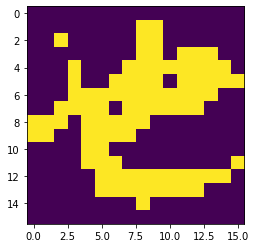

In [7]:
fname = '../data/shufadict/clean/也/49ad5ddd4dfd11874212f56d02d88355.png'

f = cv2.imread(fname)[:, :, 0]
f = preprocess_image_moment(f, N)
plt.imshow(f)

ekmi = EKMI(N, M)

tik = time.time()
Q = ekmi.get_moment(f, order)
tok = time.time()
print(tok - tik)

get_feature_vec(Q)

In [11]:
samples_source = [[None] * sample_per_class for _ in range(len(chars))]
samples = np.empty(shape=(len(chars), sample_per_class, (order + 1) ** 2 - 1))

ekmi = EKMI(N, M)

for char in chars:
    fnames = glob.glob('{}/{}/*.png'.format(DATA_PATH, char))
    random.shuffle(fnames)
    for i, fname in tqdm(enumerate(fnames[:sample_per_class]), total=sample_per_class, desc=char):
        f = cv2.imread(fname)[:, :, 0]
        f = preprocess_image_moment(f, N)
        Q = ekmi.get_moment(f, order)
        samples[char_to_id[char], i, :] = get_feature_vec(Q)
        samples_source[char_to_id[char]][i] = fname

后:   0%|          | 0/30 [00:00<?, ?it/s]

家:   0%|          | 0/30 [00:00<?, ?it/s]

无:   0%|          | 0/30 [00:00<?, ?it/s]

和:   0%|          | 0/30 [00:00<?, ?it/s]

如:   0%|          | 0/30 [00:00<?, ?it/s]

多:   0%|          | 0/30 [00:00<?, ?it/s]

有:   0%|          | 0/30 [00:00<?, ?it/s]

最:   0%|          | 0/30 [00:00<?, ?it/s]

面:   0%|          | 0/30 [00:00<?, ?it/s]

要:   0%|          | 0/30 [00:00<?, ?it/s]

国:   0%|          | 0/30 [00:00<?, ?it/s]

女:   0%|          | 0/30 [00:00<?, ?it/s]

好:   0%|          | 0/30 [00:00<?, ?it/s]

看:   0%|          | 0/30 [00:00<?, ?it/s]

着:   0%|          | 0/30 [00:00<?, ?it/s]

在:   0%|          | 0/30 [00:00<?, ?it/s]

己:   0%|          | 0/30 [00:00<?, ?it/s]

小:   0%|          | 0/30 [00:00<?, ?it/s]

现:   0%|          | 0/30 [00:00<?, ?it/s]

就:   0%|          | 0/30 [00:00<?, ?it/s]

把:   0%|          | 0/30 [00:00<?, ?it/s]

发:   0%|          | 0/30 [00:00<?, ?it/s]

手:   0%|          | 0/30 [00:00<?, ?it/s]

起:   0%|          | 0/30 [00:00<?, ?it/s]

可:   0%|          | 0/30 [00:00<?, ?it/s]

们:   0%|          | 0/30 [00:00<?, ?it/s]

过:   0%|          | 0/30 [00:00<?, ?it/s]

情:   0%|          | 0/30 [00:00<?, ?it/s]

而:   0%|          | 0/30 [00:00<?, ?it/s]

以:   0%|          | 0/30 [00:00<?, ?it/s]

心:   0%|          | 0/30 [00:00<?, ?it/s]

从:   0%|          | 0/30 [00:00<?, ?it/s]

能:   0%|          | 0/30 [00:00<?, ?it/s]

中:   0%|          | 0/30 [00:00<?, ?it/s]

美:   0%|          | 0/30 [00:00<?, ?it/s]

会:   0%|          | 0/30 [00:00<?, ?it/s]

个:   0%|          | 0/30 [00:00<?, ?it/s]

也:   0%|          | 0/30 [00:00<?, ?it/s]

事:   0%|          | 0/30 [00:00<?, ?it/s]

想:   0%|          | 0/30 [00:00<?, ?it/s]

之:   0%|          | 0/30 [00:00<?, ?it/s]

一:   0%|          | 0/30 [00:00<?, ?it/s]

当:   0%|          | 0/30 [00:00<?, ?it/s]

总:   0%|          | 0/30 [00:00<?, ?it/s]

然:   0%|          | 0/30 [00:00<?, ?it/s]

你:   0%|          | 0/30 [00:00<?, ?it/s]

人:   0%|          | 0/30 [00:00<?, ?it/s]

子:   0%|          | 0/30 [00:00<?, ?it/s]

日:   0%|          | 0/30 [00:00<?, ?it/s]

时:   0%|          | 0/30 [00:00<?, ?it/s]

In [22]:
with open('samples_source.json', 'w') as f:
    json.dump(samples_source, f)
    
with open('samples.npy', 'wb') as f:
    np.save(f, samples)

In [16]:
# with open('samples.npy', 'rb') as f:
#     samples_loaded = np.load(f)
    
# with open('samples_source.json', 'r') as f:
#     samples_source_loaded = json.load(f)

In [35]:
train_source = [x[:-5] for x in samples_source]
train = samples[:, :-5, :]
test_source = [x[-5:] for x in samples_source]
test = samples[:, -5:, :]

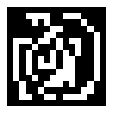

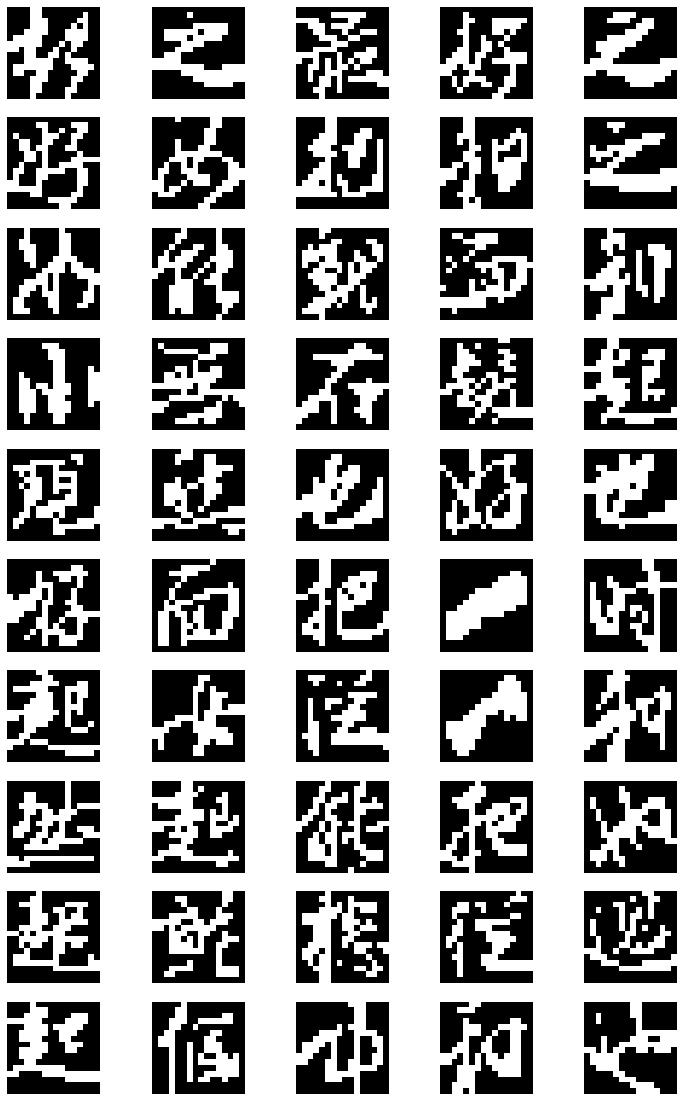

In [135]:
test_cid, test_i = 10, 4
test_sample = test[test_cid, test_i, :]

test_img = cv2.imread(test_source[test_cid][test_i])
test_img = preprocess_image_moment(test_img[:, :, 0], N)
show([test_img])

tmp = ((train - test_sample) ** 2).sum(axis=2)
pred_cids = tmp.reshape(-1).argsort()[:50]
pred_imgs = [None] * 50
for i,  pred_cid in enumerate(pred_cids):
    pred_cid, pred_i = pred_cid // tmp.shape[1], pred_cid % tmp.shape[1]
    pred_imgs[i] = cv2.imread(train_source[pred_cid][pred_i])
    pred_imgs[i] = preprocess_image_moment(pred_imgs[i][:, :, 0], N)
show(pred_imgs)